In [1]:
# use cellXgene2 conda env
import pandas as pd
import scanpy as sc 
import os
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr, spearmanr, mannwhitneyu, ttest_ind, ttest_rel, wilcoxon, kruskal, f_oneway
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf
import random

In [ ]:
# color rules
# more dream expression is darker color magma

# Read data

In [349]:
tms_data_dir = "/cellar/users/zkoch/dream/data/tabula_muris_senis"
facs_fn = "tabula-muris-senis-facs-processed-official-annotations.h5ad"
facs_raw_fn = "tabula-muris-senis-facs-official-raw-obj.h5ad"

# read in data
facs = sc.read_h5ad(os.path.join(tms_data_dir, facs_fn))
facs_raw = sc.read_h5ad(os.path.join(tms_data_dir, facs_raw_fn))
mutations = pd.read_excel(os.path.join(tms_data_dir,'supplementary_table_8.xlsx'))

/cellar/users/zkoch/miniconda3/envs/cellXgene2/lib/python3.8/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/cellar/users/zkoch/miniconda3/envs/cellXgene2/lib/python3.8/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [350]:
# adata: is the average number of mutations per cell in the gene set of the tissue
# adata_raw_counts: are the average number of gene counts per cell

mutations.rename(columns={'adata':'mutation_count'}, inplace=True)
facs.obs.rename(columns={'cell_ontology_class':'cell_type'}, inplace=True)
facs_raw.obs.rename(columns={'cell_ontology_class':'cell_type'}, inplace=True)
# create columns and remove _s
facs.obs['age_months'] = facs.obs['age'].str[:-1].astype(int)
facs.obs['tissue'] = facs.obs['tissue'].str.replace('_', ' ')
facs.obs['subtissue'] = facs.obs['subtissue'].str.replace('_', ' ')
facs.obs['cell_type'] = facs.obs['cell_type'].str.replace('_', ' ')
# raw
facs_raw.obs['age_months'] = facs_raw.obs['age'].str[:-1].astype(int)
facs_raw.obs['tissue'] = facs_raw.obs['tissue'].str.replace('_', ' ')
facs_raw.obs['subtissue'] = facs_raw.obs['subtissue'].str.replace('_', ' ')
facs_raw.obs['cell_type'] = facs_raw.obs['cell_type'].str.replace('_', ' ')
# change gene names to uppercase
facs.var_names = [x.upper() for x in facs.var_names]
facs_raw.var_names = [x.upper() for x in facs_raw.var_names]
# add tissue_num and age_m
facs.obs['tissue_num'] = facs.obs['tissue'].astype('category').cat.codes
facs_raw.obs['tissue_num'] = facs_raw.obs['tissue'].astype('category').cat.codes
# bring over old umap
# get a list of indices where facs_raw.obs.index and facs.obs.index are the same
shared_cells = list(set(facs_raw.obs.index).intersection(set(facs.obs.index)))
# get the indices of these cells in facs.obs
facs_shared_cells_idx = [facs.obs.index.get_loc(x) for x in shared_cells]
facs_raw_shared_cells_idx = [facs_raw.obs.index.get_loc(x) for x in shared_cells]

# re-order facs_raw to match facs
facs_raw.obs = facs_raw.obs.iloc[facs_raw_shared_cells_idx, :]
facs_raw.X = facs_raw.X[facs_raw_shared_cells_idx, :]

# match cell ids
facs_raw.obsm['X_umap'] = facs.obsm['X_umap'][facs_shared_cells_idx]
facs_raw.obsm['X_pca'] = facs.obsm['X_pca'][facs_shared_cells_idx]

# combine facs and facs_raw uns
facs_raw.uns = {**facs_raw.uns, **facs.uns}


# the # of genes expressed in 75% of cells across all ages in a tissue
# this is the set of genes across which mutation counts were averaged
# from https://github.com/czbiohub-sf/tabula-muris-senis/blob/master/1_tabula_muris_senis/13_figure_3/tabula-muris-senis-mutation-analysis.ipynb
genes_w_called_mutations = {
    'Bladder': 6,
    'Trachea': 10,
    'Brain_Myeloid': 158,
    'Liver': 113,
    'Brain_Non-Myeloid':42,
    'Aorta': 108,
    'Large_Intestine': 11,
    'Skin' :371,
    'Lung': 139,
    'BAT' :77,
    'Kidney': 65,
    'Tongue': 540,
    'Marrow': 51,
    'GAT' :226,
    'Thymus': 142,
    'Spleen' :15,
    'Limb_Muscle': 146,
    'Diaphragm': 101,
    'MAT' :194,
    'Pancreas' :39,
    'Mammary_Gland': 711,
    'SCAT' :157,
    'Heart': 122
    }
mutations['num_genes_w_called_mutations'] = mutations['tissue'].map(genes_w_called_mutations)
mutations['raw_mutation_count'] = mutations['mutation_count'] * mutations['num_genes_w_called_mutations']

# Pre-process

In [351]:
sc.settings.verbosity = 3
facs_raw.var_names_make_unique() # i checked and doens't change anything
# filter out cells with less than 200 genes or genes expressed in less than 3 cells
sc.pp.filter_cells(facs_raw, min_genes=200)
sc.pp.filter_genes(facs_raw, min_cells=3)
# calculate n_genes_by_counts and total_counts
sc.pp.calculate_qc_metrics(
    facs_raw, percent_top=None, log1p=False, inplace=True
    )
sc.pp.calculate_qc_metrics(
    facs, percent_top=None, log1p=False, inplace=True
    )
# filter out outliers with more than 10,000,000 total counts
facs_raw.obs['outlier_total_counts'] = facs_raw.obs.total_counts > 10000000
print(f"filtering out {sum(facs_raw.obs['outlier_total_counts'])} cells with more than 10,000,000 total counts out of {facs_raw.shape[0]} cells")
facs_raw = facs_raw[~facs_raw.obs['outlier_total_counts'], :]
facs.obs['outlier_total_counts'] = facs.obs.total_counts > 10000000
print(f"filtering out {sum(facs.obs['outlier_total_counts'])} cells with more than 10,000,000 total counts out of {facs.shape[0]} cells")
facs = facs[~facs.obs['outlier_total_counts'], :]

# 
sc.experimental.pp.normalize_pearson_residuals(facs_raw)

# Normalize each cell by total counts over all genes
# median total counts is 800,000 so use 1e6
# median_total_counts = np.median(facs_raw.obs['total_counts'])
"""sc.pp.normalize_total(facs_raw, target_sum=1e6) # CPM normalization
sc.pp.log1p(facs_raw)
sc.pp.scale(facs_raw, zero_center=False)"""

filtered out 13 genes that are detected in less than 3 cells
filtering out 454 cells with more than 10,000,000 total counts out of 110824 cells
filtering out 0 cells with more than 10,000,000 total counts out of 110824 cells


/cellar/users/zkoch/miniconda3/envs/cellXgene2/lib/python3.8/site-packages/scanpy/experimental/pp/_normalization.py:122: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing analytic Pearson residuals on adata.X
    finished (0:00:32)


'sc.pp.normalize_total(facs_raw, target_sum=1e6) # CPM normalization\nsc.pp.log1p(facs_raw)\nsc.pp.scale(facs_raw, zero_center=False)'

In [352]:
# add mutations to expression data
mutations['short_cell_name'] = mutations['cell'].str.split('_').str[:2].str.join('_')
facs.obs['short_cell_name'] = facs.obs['cell'].str.split('_').str[:2].str.join('_')
facs_raw.obs['short_cell_name'] = facs_raw.obs['cell'].str.split('_').str[:2].str.join('_')
# merge on short_cell_name and rename adata to mutation_count
facs.obs = facs.obs.merge(
    mutations[['mutation_count','raw_mutation_count','num_genes_w_called_mutations', 'short_cell_name']], left_on='short_cell_name',
    right_on = 'short_cell_name', how='left'
    )
facs_raw.obs = facs_raw.obs.merge(
    mutations[['mutation_count','raw_mutation_count','num_genes_w_called_mutations', 'short_cell_name']], left_on='short_cell_name',
    right_on = 'short_cell_name', how='left'
    )

/tmp/ipykernel_392555/2265881189.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  facs.obs['short_cell_name'] = facs.obs['cell'].str.split('_').str[:2].str.join('_')


In [353]:
# read in dream gene list
dream_genes = pd.read_csv(
    "/cellar/users/zkoch/dream/data/bujarrabal_dueso/tableS12_dream_promoter_binding.csv"
    )
#dream_genes.query("`DNA repair genes` == 1", inplace=True)

genes_w_expr = facs.var_names
dream_genes_w_expr = list(set(genes_w_expr).intersection(set(dream_genes['Gene name'])))
print("number of dream genes with expression", len(dream_genes_w_expr))
mean_dream_activity = facs[:, dream_genes_w_expr].X.mean(axis=1)
facs.obs['mean_dream_activity'] = mean_dream_activity

# my_processed ata
genes_w_expr = facs_raw.var_names
dream_genes_w_expr = list(set(genes_w_expr).intersection(set(dream_genes['Gene name'])))
print("number of dream genes with expression", len(dream_genes_w_expr))
mean_dream_activity = facs_raw[:, dream_genes_w_expr].X.mean(axis=1)
facs_raw.obs['mean_dream_activity'] = mean_dream_activity

facs.obs['overrall_mean_gene_expr'] = facs.X.mean(axis=1)
facs_raw.obs['overrall_mean_gene_expr'] = facs_raw.X.mean(axis=1)

number of dream genes with expression 249
number of dream genes with expression 249


# Analysis

### Get residual mutation and dream activity

In [88]:
# more reads and genes => greater mean dream activity
# with log and normalization
facs.obs[['mean_dream_activity', 'n_counts', 'n_genes']].corr(method='spearman')

mean_dream_activity  n_counts   n_genes
mean_dream_activity              1.00000  0.188110  0.660360
n_counts                         0.18811  1.000000  0.390329
n_genes                          0.66036  0.390329  1.000000

In [89]:
# with pearson resid
facs_raw.obs[['mean_dream_activity', 'n_counts', 'n_genes']].corr(method='spearman')

mean_dream_activity  n_counts   n_genes
mean_dream_activity             1.000000 -0.306520  0.057323
n_counts                       -0.306520  1.000000  0.391998
n_genes                         0.057323  0.391998  1.000000

In [90]:
# more reads and genes more mutations
facs_raw.obs[['mutation_count', 'raw_mutation_count', 'n_counts', 'n_genes']].corr(method='spearman')

mutation_count  raw_mutation_count  n_counts   n_genes
mutation_count            1.000000            0.666088  0.313397  0.110685
raw_mutation_count        0.666088            1.000000  0.176930  0.034464
n_counts                  0.313397            0.176930  1.000000  0.391998
n_genes                   0.110685            0.034464  0.391998  1.000000

In [354]:
mut_ols = smf.ols(
    formula='mutation_count ~ n_counts * n_genes', data=facs_raw.obs
    ).fit()
facs_raw.obs['mutation_count_resid'] = mut_ols.resid

mut_ols = smf.ols(
    formula='raw_mutation_count ~ n_counts * n_genes', data=facs_raw.obs
    ).fit()
facs_raw.obs['raw_mutation_count_resid'] = mut_ols.resid

mut_ols = smf.ols(
    formula='mutation_count ~ n_counts * n_genes', data=facs.obs
    ).fit()
facs.obs['mutation_count_resid'] = mut_ols.resid

mut_ols = smf.ols(
    formula='mutation_count ~ n_counts * num_genes_w_called_mutations', data=facs.obs
    ).fit()
facs.obs['mutation_count_resid2'] = mut_ols.resid

mut_ols = smf.ols(
    formula='raw_mutation_count ~ n_counts * n_genes', data=facs.obs
    ).fit()
facs.obs['raw_mutation_count_resid'] = mut_ols.resid

mut_ols = smf.ols(
    formula='mean_dream_activity ~ n_counts * n_genes', data=facs.obs
    ).fit()
facs.obs['mean_dream_activity_resid'] = mut_ols.resid

In [355]:
# scale residuals to have minimum value of 0
facs.obs['mean_dream_activity_resid'] = facs.obs['mean_dream_activity_resid'] - min(facs.obs['mean_dream_activity_resid'])

In [93]:
# more reads and genes more mutations
facs_raw.obs[['mutation_count', 'mutation_count_resid', 'raw_mutation_count', 'raw_mutation_count_resid', 'n_counts', 'n_genes']].corr(method='spearman')

mutation_count  mutation_count_resid  \
mutation_count                  1.000000              0.967389   
mutation_count_resid            0.967389              1.000000   
raw_mutation_count              0.666088              0.657258   
raw_mutation_count_resid        0.534165              0.568961   
n_counts                        0.313397              0.125215   
n_genes                         0.110685              0.060874   

                          raw_mutation_count  raw_mutation_count_resid  \
mutation_count                      0.666088                  0.534165   
mutation_count_resid                0.657258                  0.568961   
raw_mutation_count                  1.000000                  0.895779   
raw_mutation_count_resid            0.895779                  1.000000   
n_counts                            0.176930                 -0.061472   
n_genes                             0.034464                 -0.270002   

                          n_counts   n_genes  
mutation_count            0.313397  0.110685  
mutation_count_resid      0.125215  0.060874  
raw_mutation_count        0.176930  0.034464  
raw_mutation_count_resid -0.061472 -0.270002  
n_counts                  1.000000  0.391998  
n_genes                   0.391998  1.000000

In [96]:
# we expect that the higher dream regulated dream activity (ie. lower DREAM expression) the fewer mutations
facs_raw.obs.groupby(['tissue', 'age'])[['mean_dream_activity', 'mutation_count']].corr(method='spearman').iloc[0::2, -1].describe()

count    69.000000
mean     -0.115288
std       0.169299
min      -0.531293
25%      -0.183727
50%      -0.113210
75%      -0.014032
max       0.345732
Name: mutation_count, dtype: float64

In [99]:
# we expect that the higher dream regulated dream activity (ie. lower DREAM expression) the fewer mutations
facs.obs.groupby(['tissue', 'age'])[['mean_dream_activity', 'mutation_count']].corr(method='spearman').iloc[0::2, -1].describe()

count    69.000000
mean      0.278246
std       0.196462
min      -0.160779
25%       0.152102
50%       0.322094
75%       0.414097
max       0.596574
Name: mutation_count, dtype: float64

# DREAM activity by age and tissue

/tmp/ipykernel_169527/1803980051.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = facs_raw.obs, y = 'mean_dream_activity', x = 'age', palette='magma_r', showfliers = False, order = ['3m', '18m', '24m'], ax=ax)


Ttest_indResult(statistic=22.728688321589946, pvalue=5.4612888142598774e-114)
Ttest_indResult(statistic=22.74854961613253, pvalue=3.586028897085424e-114)
Ttest_indResult(statistic=0.663137271194715, pvalue=0.5072449888871826)


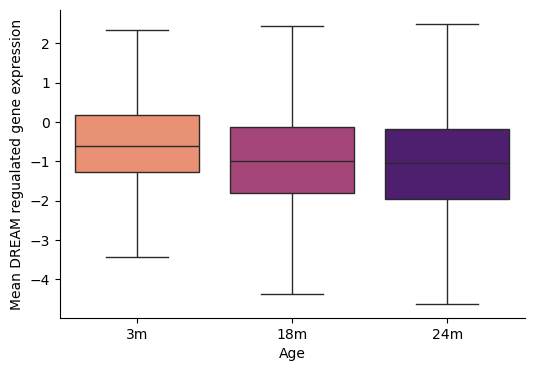

In [321]:
fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(data = facs_raw.obs, y = 'mean_dream_activity', x = 'age', palette='magma_r', showfliers = False, order = ['3m', '18m', '24m'], ax=ax)
# test for significance
from scipy.stats import ttest_ind
print(ttest_ind(facs_raw.obs.query('age == "3m"')['mean_dream_activity'], facs_raw.obs.query('age == "18m"')['mean_dream_activity']))
print(ttest_ind(facs_raw.obs.query('age == "3m"')['mean_dream_activity'], facs_raw.obs.query('age == "24m"')['mean_dream_activity']))
print(ttest_ind(facs_raw.obs.query('age == "18m"')['mean_dream_activity'], facs_raw.obs.query('age == "24m"')['mean_dream_activity']))
plt.xlabel('Age')
plt.ylabel('Mean DREAM regualated gene expression')
sns.despine()


Text(0, 0.5, 'Mean DREAM regulated gene expression')

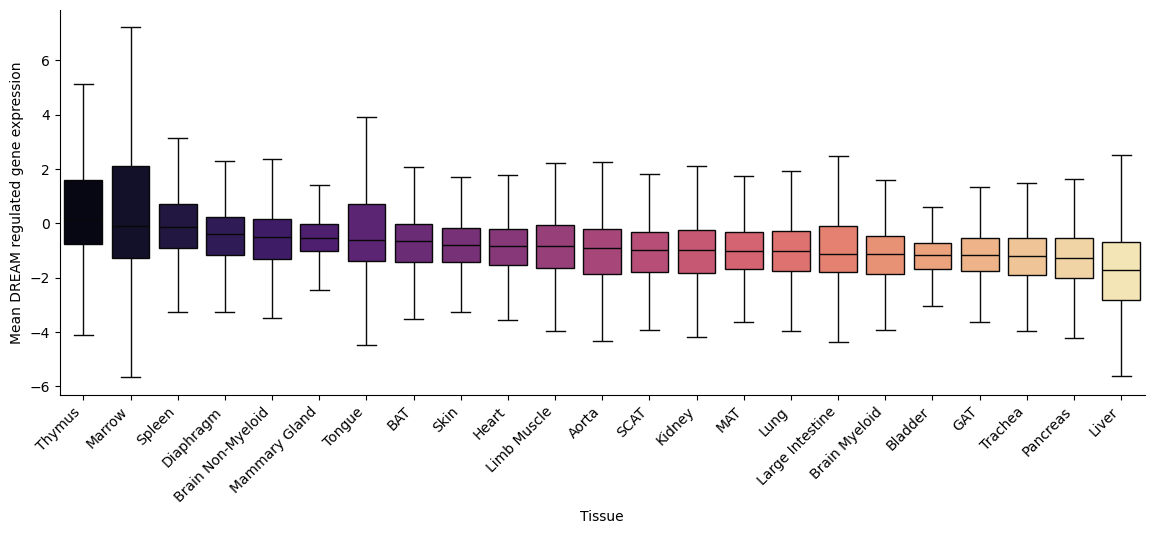

In [323]:
fig, axes = plt.subplots( figsize=(14,5))
order = facs_raw.obs.groupby(['tissue'])['mean_dream_activity'].median().sort_values(ascending=False).index

sns.boxplot(
    data = facs_raw.obs, y = 'mean_dream_activity', x = 'tissue', hue = 'tissue',
    palette='magma', showfliers = False,
    ax = axes, order = order, hue_order=order,
    legend = False
    )
# angle x labels
_ = plt.xticks(rotation=45, ha='right')
sns.despine()
plt.xlabel('Tissue')
plt.ylabel('Mean DREAM regulated gene expression')


Text(0, 0.5, 'Mean DREAM regulated gene expression')

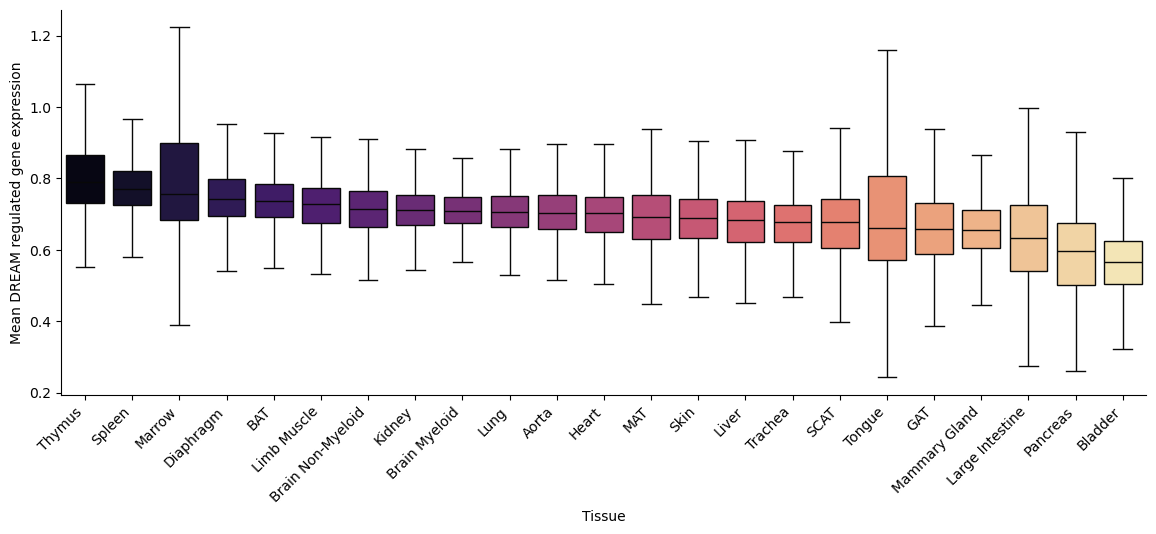

In [278]:
fig, axes = plt.subplots( figsize=(14,5))
order = facs.obs.groupby(['tissue'])['mean_dream_activity_resid'].median().sort_values(ascending=False).index

sns.boxplot(
    data = facs.obs, y = 'mean_dream_activity_resid', x = 'tissue', hue = 'tissue',
    palette='magma', showfliers = False,
    ax = axes, order = order, hue_order=order,
    legend = False
    )
# angle x labels
_ = plt.xticks(rotation=45, ha='right')
sns.despine()
plt.xlabel('Tissue')
plt.ylabel('Mean DREAM regulated gene expression')


# Mutation burden by tissue and age

In [102]:
facs_raw.obs.query("age_months != 21", inplace=True)

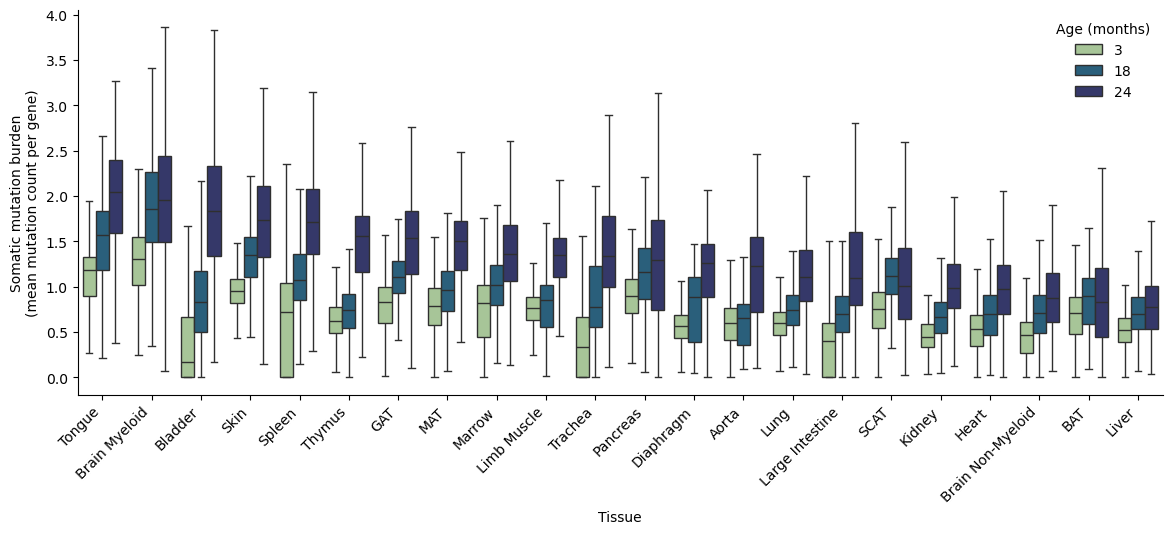

In [109]:
fig, axes = plt.subplots( figsize=(14,5))
# within each age, bin the mean_dream_activity into 3 bins
order = facs_raw.obs.groupby(['tissue', 'age_months'])['mutation_count'].median().sort_values(ascending=False).reset_index().query('age_months == 24')['tissue']
sns.boxplot(
    data = facs_raw.obs, y = 'mutation_count', x = 'tissue',
    hue = 'age_months', palette='crest', showfliers = False,
    ax = axes, order = order, hue_order=[3, 18, 24]
    )
# angle x labels
_ = plt.xticks(rotation=45, ha='right')
plt.xlabel('Tissue')
plt.ylabel('Somatic mutation burden\n(mean mutation count per gene)')
# remove legend border
plt.legend(title='Age (months)', frameon=False)

sns.despine()

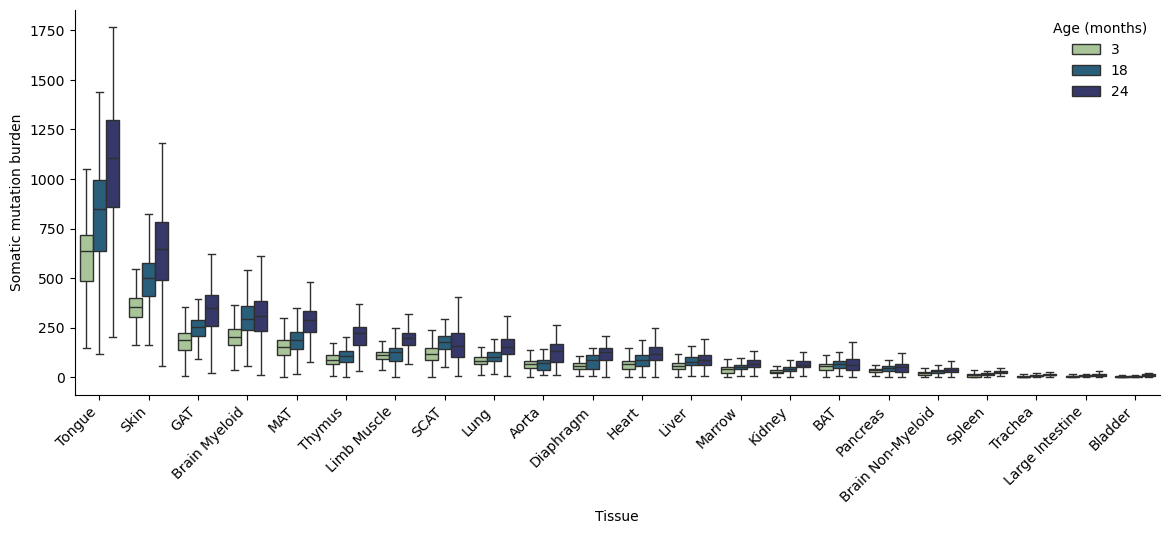

In [110]:
fig, axes = plt.subplots( figsize=(14,5))
# within each age, bin the mean_dream_activity into 3 bins
order = facs_raw.obs.groupby(['tissue', 'age_months'])['raw_mutation_count'].median().sort_values(ascending=False).reset_index().query('age_months == 24')['tissue']
sns.boxplot(
    data = facs_raw.obs, y = 'raw_mutation_count', x = 'tissue',
    hue = 'age_months', palette='crest', showfliers = False,
    ax = axes, order = order, hue_order=[3, 18, 24]
    )
# angle x labels
_ = plt.xticks(rotation=45, ha='right')
plt.xlabel('Tissue')
plt.ylabel('Somatic mutation burden')
# remove legend border
plt.legend(title='Age (months)', frameon=False)

sns.despine()

# DREAM activity vs. mutation rate

In [106]:
magma_categorical = plt.cm.get_cmap('magma', 10)
crest_categorical = plt.cm.get_cmap('crest', 10)

/tmp/ipykernel_392555/1714649841.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  magma_categorical = plt.cm.get_cmap('magma', 10)
/tmp/ipykernel_392555/1714649841.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  crest_categorical = plt.cm.get_cmap('crest', 10)


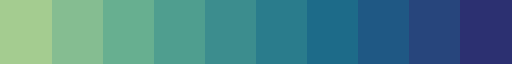

In [371]:
crest_categorical

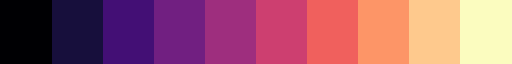

In [326]:
magma_categorical

/tmp/ipykernel_392555/2433948398.py:7: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


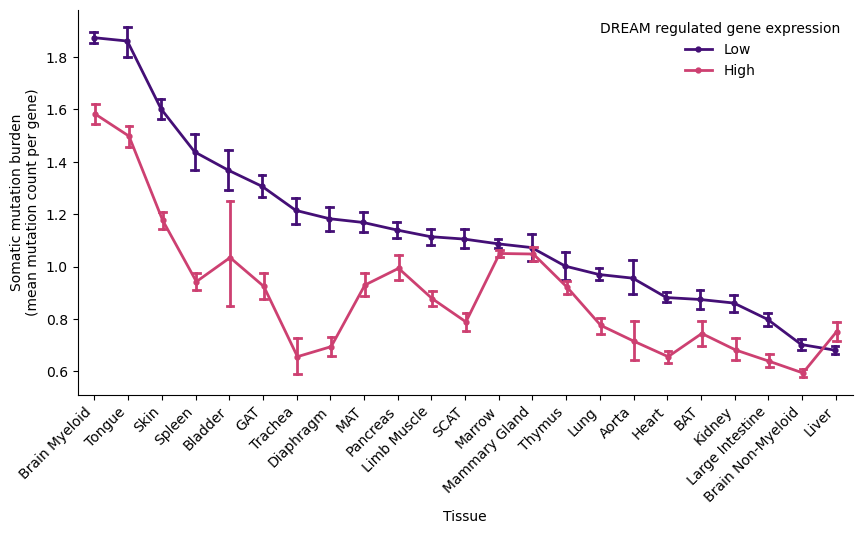

In [135]:
fig, axes = plt.subplots( figsize=(10,5))
# within each age, bin the mean_dream_activity into 3 bins
facs_raw.obs['dream_activity_bin'] = facs_raw.obs['mean_dream_activity'].transform(lambda x: pd.qcut(x, 5, labels = ['Low', 'Low-Medium', 'Medium', 'Medium-High', 'High']))

order = facs_raw.obs.groupby(['tissue', 'dream_activity_bin'])['mutation_count'].mean().sort_values(ascending=False).reset_index().query("dream_activity_bin == 'Low'")['tissue']

sns.pointplot(
    data = facs_raw.obs, y = 'mutation_count', x = 'tissue',
    hue = 'dream_activity_bin', # showfliers = False,
    hue_order=['Low', 'High'], palette=[magma_categorical(2), magma_categorical(5)],
    ax = axes, order = order, errorbar = 'ci', join=True, dodge=True, capsize=.2, 
    # make lines thinner
    linewidth = 2, markersize = 3, orient = 'v', 
    # make point not overlap
    )
# angle x labels
_ = plt.xticks(rotation=45, ha='right')
plt.xlabel('Tissue')
plt.ylabel('Somatic mutation burden\n(mean mutation count per gene)')
plt.legend(title='DREAM regulated gene expression', frameon=False)
sns.despine()

/tmp/ipykernel_392555/650379922.py:7: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


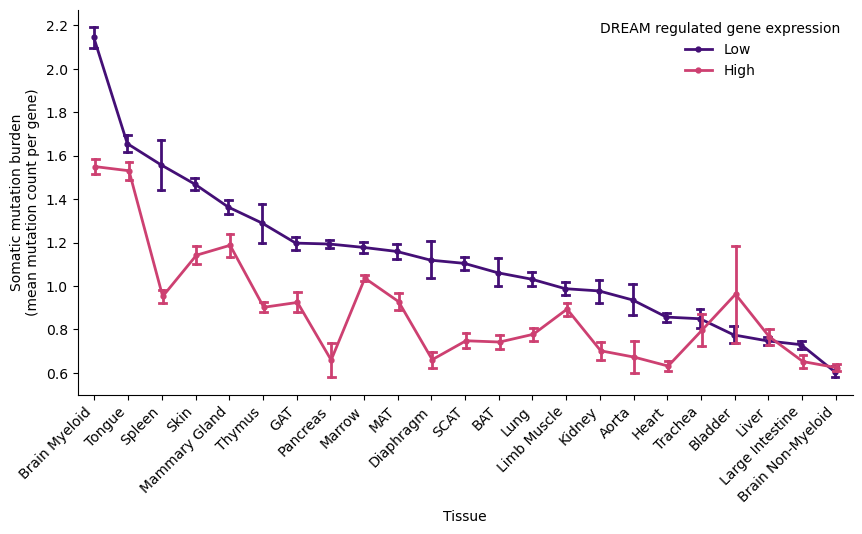

In [285]:
fig, axes = plt.subplots( figsize=(10,5))
# within each age, bin the mean_dream_activity into 3 bins
facs.obs['dream_activity_bin'] = facs.obs.groupby(['age'])['mean_dream_activity_resid'].transform(lambda x: pd.qcut(x, 5, labels = ['Low', 'Low-Medium', 'Medium', 'Medium-High', 'High']))

order = facs.obs.groupby(['tissue', 'dream_activity_bin'])['mutation_count'].mean().sort_values(ascending=False).reset_index().query("dream_activity_bin == 'Low'")['tissue']

sns.pointplot(
    data = facs.obs, y = 'mutation_count', x = 'tissue',
    hue = 'dream_activity_bin', # showfliers = False,
    hue_order=['Low', 'High'], palette=[magma_categorical(2), magma_categorical(5)],
    ax = axes, order = order, errorbar = 'ci', join=True, dodge=True, capsize=.2, 
    # make lines thinner
    linewidth = 2, markersize = 3, orient = 'v', 
    # make point not overlap
    )
# angle x labels
_ = plt.xticks(rotation=45, ha='right')
plt.xlabel('Tissue')
plt.ylabel('Somatic mutation burden\n(mean mutation count per gene)')
plt.legend(title='DREAM regulated gene expression', frameon=False)
sns.despine()

In [137]:
facs_raw.obs['top_20_mut_and_bottom_20_dream'] = (facs_raw.obs['mean_dream_activity_q'] == 'Highest 20%') & (facs_raw.obs['mutation_count_q'] == 'Lowest 20%')
facs_raw.obs['top_20_mut_and_not_bottom_20_dream'] = (facs_raw.obs['mean_dream_activity_q'] != 'Highest 20%') & (facs_raw.obs['mutation_count_q'] == 'Lowest 20%')
facs_raw.obs['not_top_20_mut_and_bottom_20_dream'] = (facs_raw.obs['mean_dream_activity_q'] == 'Highest 20%') & (facs_raw.obs['mutation_count_q'] != 'Lowest 20%')
# same in reverse
facs_raw.obs['bottom_20_mut_and_top_20_dream'] = (facs_raw.obs['mean_dream_activity_q'] == 'Lowest 20%') & (facs_raw.obs['mutation_count_q'] == 'Highest 20%')
facs_raw.obs['bottom_20_mut_and_not_top_20_dream'] = (facs_raw.obs['mean_dream_activity_q'] != 'Lowest 20%') & (facs_raw.obs['mutation_count_q'] == 'Highest 20%')
facs_raw.obs['not_bottom_20_mut_and_top_20_dream'] = (facs_raw.obs['mean_dream_activity_q'] == 'Lowest 20%') & (facs_raw.obs['mutation_count_q'] != 'Highest 20%')
# merge top_20_mut_and_bottom_20_dream, top_20_mut_and_not_bottom_20_dream, etc rows into one column
facs_raw.obs['top_20_mut_and_bottom_20_dream'] = facs_raw.obs['top_20_mut_and_bottom_20_dream'].replace({True: 'top_20_mut_and_bottom_20_dream', False: ''})
facs_raw.obs['top_20_mut_and_not_bottom_20_dream'] = facs_raw.obs['top_20_mut_and_not_bottom_20_dream'].replace({True: 'top_20_mut_and_not_bottom_20_dream', False: ''})
facs_raw.obs['not_top_20_mut_and_bottom_20_dream'] = facs_raw.obs['not_top_20_mut_and_bottom_20_dream'].replace({True: 'not_top_20_mut_and_bottom_20_dream', False: ''})
facs_raw.obs['bottom_20_mut_and_top_20_dream'] = facs_raw.obs['bottom_20_mut_and_top_20_dream'].replace({True: 'bottom_20_mut_and_top_20_dream', False: ''})
facs_raw.obs['bottom_20_mut_and_not_top_20_dream'] = facs_raw.obs['bottom_20_mut_and_not_top_20_dream'].replace({True: 'bottom_20_mut_and_not_top_20_dream', False: ''})
facs_raw.obs['not_bottom_20_mut_and_top_20_dream'] = facs_raw.obs['not_bottom_20_mut_and_top_20_dream'].replace({True: 'not_bottom_20_mut_and_top_20_dream', False: ''})
# merge into one column
facs_raw.obs['dream_mut_quintiles'] = facs_raw.obs[['top_20_mut_and_bottom_20_dream', 'top_20_mut_and_not_bottom_20_dream', 'not_top_20_mut_and_bottom_20_dream', 'bottom_20_mut_and_top_20_dream', 'bottom_20_mut_and_not_top_20_dream', 'not_bottom_20_mut_and_top_20_dream']].fillna('').agg(''.join, axis=1)


/tmp/ipykernel_392555/3471289938.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  magma_categorical = plt.cm.get_cmap('magma', 10)
/tmp/ipykernel_392555/3471289938.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  crest_categorical = plt.cm.get_cmap('crest', 10)
/cellar/users/zkoch/miniconda3/envs/cellXgene2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/zkoch/miniconda3/envs/cellXgene2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping pro

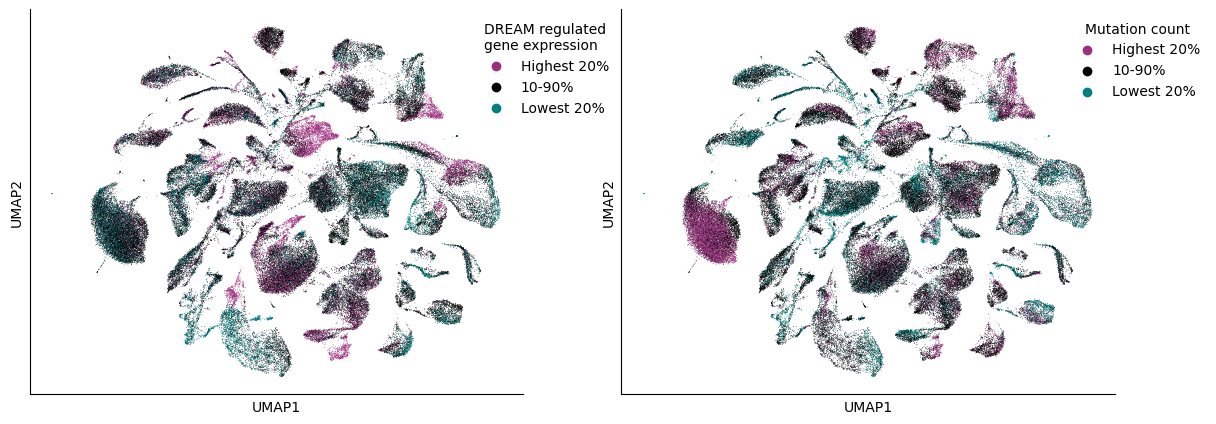

In [314]:
magma_categorical = plt.cm.get_cmap('magma', 10)
crest_categorical = plt.cm.get_cmap('crest', 10)


fig, axes = plt.subplots(1,2 ,figsize=(14,5))
# plot facs umap
facs_raw.obs['mean_dream_activity_q'] = pd.qcut(
    facs_raw.obs['mean_dream_activity'], 5,
    labels = ['Lowest 20%', '10-90%_2', '10-90%_3', '10-90%_4','Highest 20%']
    #labels = ['Lowest 10%', '10-20%', '10-90%_2', '10-90%_3', '10-90%_4', '10-90%_5', '10-90%_6', '10-90%_7', '10-90%_8', 'Highest 10%']
)
facs_raw.obs['mutation_count_q'] = pd.qcut(
    facs_raw.obs['mutation_count'],5,
    labels=['Lowest 20%', '10-90%_2', '10-90%_3', '10-90%_4','Highest 20%']
    #labels = ['Lowest 10%', '10-20%!', '10-90%_2', '10-90%_3', '10-90%_4', '10-90%_5', '10-90%_6', '10-90%_7', '10-90%_8', 'Highest 10%']
)
# drop _1, _2, _3
facs_raw.obs['mean_dream_activity_q'] = facs_raw.obs['mean_dream_activity_q'].str.split('_').str[0]
facs_raw.obs['mutation_count_q'] = facs_raw.obs['mutation_count_q'].str.split('_').str[0]

sc.pl.umap(
    facs_raw, color = ['mean_dream_activity_q'], ax = axes[0], 
    show = False,#palette = 'magma',
    palette=['black',  magma_categorical(4),'teal']
    )
sc.pl.umap(
    facs_raw, color = ['mutation_count_q'], ax = axes[1],
    show=False,# palette = 'magma',
    palette=['black', magma_categorical(4), 'teal' ]
    )
axes[0].legend_.set_title('DREAM regulated gene expression')
axes[1].legend_.set_title('Mutation count')

# change order of legend
handles, labels = axes[0].get_legend_handles_labels()
# no background color on legend

axes[0].legend(
    [handles[1], handles[0], handles[2]], [labels[1], labels[0], labels[2]],
    title = 'DREAM regulated\ngene expression',bbox_to_anchor=(1.2, 1), loc='upper right',
    framealpha=0.0
    )
axes[0].legend_.get_frame()._linewidth=0.0
# second plot
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(
    [handles[1], handles[0], handles[2]], [labels[1], labels[0], labels[2]], 
    title = 'Mutation count', bbox_to_anchor=(1.2, 1), loc='upper right',
    framealpha=0.0
    )
axes[1].legend_.get_frame()._linewidth=0.0
# remove titles
axes[0].set_title('')
axes[1].set_title('')
sns.despine()

/tmp/ipykernel_392555/1297780439.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  magma_categorical = plt.cm.get_cmap('magma', 10)
/tmp/ipykernel_392555/1297780439.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  crest_categorical = plt.cm.get_cmap('crest', 10)
/cellar/users/zkoch/miniconda3/envs/cellXgene2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/zkoch/miniconda3/envs/cellXgene2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping pro

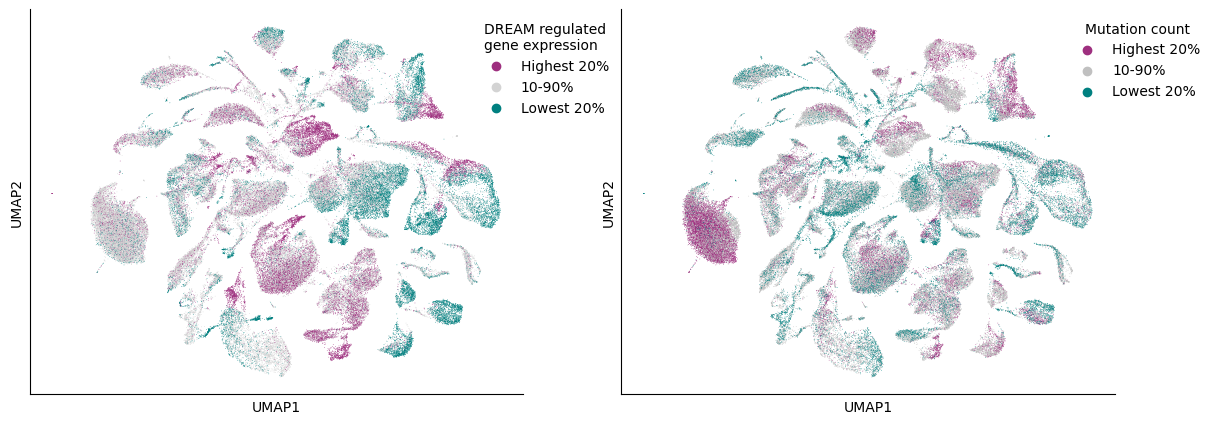

In [317]:
magma_categorical = plt.cm.get_cmap('magma', 10)
crest_categorical = plt.cm.get_cmap('crest', 10)


fig, axes = plt.subplots(1,2 ,figsize=(14,5))
# plot facs umap
facs.obs['mean_dream_activity_q'] = pd.qcut(
    facs.obs['mean_dream_activity_resid'], 5,
    labels = ['Lowest 20%', '10-90%_2', '10-90%_3', '10-90%_4','Highest 20%']
    #labels = ['Lowest 10%', '10-20%', '10-90%_2', '10-90%_3', '10-90%_4', '10-90%_5', '10-90%_6', '10-90%_7', '10-90%_8', 'Highest 10%']
)
facs.obs['mutation_count_q'] = pd.qcut(
    facs.obs['mutation_count'],5,
    labels=['Lowest 20%', '10-90%_2', '10-90%_3', '10-90%_4','Highest 20%']
    #labels = ['Lowest 10%', '10-20%!', '10-90%_2', '10-90%_3', '10-90%_4', '10-90%_5', '10-90%_6', '10-90%_7', '10-90%_8', 'Highest 10%']
)
# drop _1, _2, _3
facs.obs['mean_dream_activity_q'] = facs.obs['mean_dream_activity_q'].str.split('_').str[0]
facs.obs['mutation_count_q'] = facs.obs['mutation_count_q'].str.split('_').str[0]

sc.pl.umap(
    facs, color = ['mean_dream_activity_q'], ax = axes[0], 
    show = False,#palette = 'magma',
    palette=['lightgrey',  magma_categorical(4),'teal']
    )
sc.pl.umap(
    facs, color = ['mutation_count_q'], ax = axes[1],
    show=False,# palette = 'magma',
    palette=['silver', magma_categorical(4), 'teal' ]
    )
axes[0].legend_.set_title('DREAM regulated gene expression')
axes[1].legend_.set_title('Mutation count')

# change order of legend
handles, labels = axes[0].get_legend_handles_labels()
# no background color on legend

axes[0].legend(
    [handles[1], handles[0], handles[2]], [labels[1], labels[0], labels[2]],
    title = 'DREAM regulated\ngene expression',bbox_to_anchor=(1.2, 1), loc='upper right',
    framealpha=0.0
    )
axes[0].legend_.get_frame()._linewidth=0.0
# second plot
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(
    [handles[1], handles[0], handles[2]], [labels[1], labels[0], labels[2]], 
    title = 'Mutation count', bbox_to_anchor=(1.2, 1), loc='upper right',
    framealpha=0.0
    )
axes[1].legend_.get_frame()._linewidth=0.0
# remove titles
axes[0].set_title('')
axes[1].set_title('')
sns.despine()

Mean correlation across all cell types age_months
3    -0.068003
18   -0.109496
24   -0.145408
dtype: float64


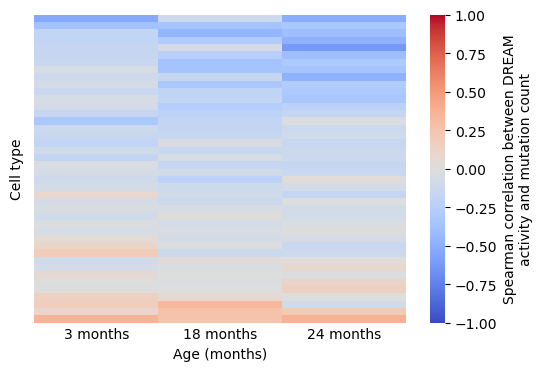

In [145]:
effect_within_cell_and_age = facs_raw.obs.groupby(['cell_type', 'age_months'])[
    ['mean_dream_activity', 'mutation_count']
    ].corr(method = 'spearman').reset_index().iloc[::2]
effect_within_cell_and_age.drop(['mean_dream_activity', 'level_2'], axis=1, inplace=True)
effect_within_cell_and_age.rename(columns={'mutation_count':r'Spearman $\rho$'}, inplace=True)

fig, axes = plt.subplots(figsize=(6,4))
# pivot effect_within_cell_and_age to have cell_type as index and age as columns
effect_within_cell_and_age_pivot = effect_within_cell_and_age.pivot(
    index='cell_type', columns='age_months', values=r'Spearman $\rho$'
    )
#effect_within_cell_and_age_pivot.drop(columns = ['21m'], inplace=True)
# drop infrequent cell types
cell_types = facs_raw.obs['cell_type'].value_counts()
freq_cell_types = cell_types[cell_types > 500].index
effect_within_cell_and_age_pivot = effect_within_cell_and_age_pivot.loc[freq_cell_types, :]
# order rows by mean coff 3m, 18m, and 24m
effect_within_cell_and_age_pivot = effect_within_cell_and_age_pivot.loc[
    effect_within_cell_and_age_pivot.mean(axis=1).sort_values(ascending=True).index
    ]
# order rows by dendrogram
#effect_within_cell_and_age_pivot = effect_within_cell_and_age_pivot.loc[facs_raw.uns['dendrogram_cell_type']['categories_ordered'][::-1], :]
# dropna axi = 0
effect_within_cell_and_age_pivot.dropna(axis=0, inplace=True)


sns.heatmap(
    data = effect_within_cell_and_age_pivot,
    cmap = 'coolwarm', ax = axes, vmin=-1, center =0 , vmax=1,
    )
# remove y tick labels
axes.set_yticklabels([])
# change x tick labels
_ = axes.set_xticklabels(['3 months', '18 months', '24 months'])
axes.set_xlabel('Age (months)')
axes.set_ylabel('Cell type')
# remove x tick lines
axes.tick_params(axis=u'both', which=u'both',length=0)
# label colorbar
cbar = axes.collections[0].colorbar
cbar.set_label('Spearman correlation between DREAM\nactivity and mutation count')
print("Mean correlation across all cell types", effect_within_cell_and_age_pivot.mean())

In [319]:
facs.obs.query("age_months != 21", inplace=True)

Mean correlation across all cell types age_months
3    -0.126007
18   -0.185723
24   -0.121914
dtype: float64


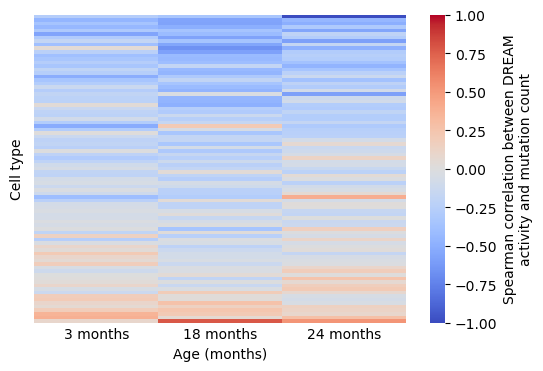

In [327]:
effect_within_cell_and_age = facs.obs.groupby(['cell_type', 'age_months'])[
    ['mean_dream_activity_resid', 'mutation_count']
    ].corr(method = 'spearman').reset_index().iloc[::2]
effect_within_cell_and_age.drop(['mean_dream_activity_resid', 'level_2'], axis=1, inplace=True)
effect_within_cell_and_age.rename(columns={'mutation_count':r'Spearman $\rho$'}, inplace=True)

fig, axes = plt.subplots(figsize=(6,4))
# pivot effect_within_cell_and_age to have cell_type as index and age as columns
effect_within_cell_and_age_pivot = effect_within_cell_and_age.pivot(
    index='cell_type', columns='age_months', values=r'Spearman $\rho$'
    )
#effect_within_cell_and_age_pivot.drop(columns = ['21m'], inplace=True)
# drop infrequent cell types
cell_types = facs.obs['cell_type'].value_counts()
freq_cell_types = cell_types[cell_types > 100].index
effect_within_cell_and_age_pivot = effect_within_cell_and_age_pivot.loc[freq_cell_types, :]
# order rows by mean coff 3m, 18m, and 24m
effect_within_cell_and_age_pivot = effect_within_cell_and_age_pivot.loc[
    effect_within_cell_and_age_pivot.mean(axis=1).sort_values(ascending=True).index
    ]
# order rows by dendrogram
#effect_within_cell_and_age_pivot = effect_within_cell_and_age_pivot.loc[facs_raw.uns['dendrogram_cell_type']['categories_ordered'][::-1], :]
# dropna axi = 0
effect_within_cell_and_age_pivot.dropna(axis=0, inplace=True)


sns.heatmap(
    data = effect_within_cell_and_age_pivot,
    cmap = 'coolwarm', ax = axes, vmin=-1, center =0 , vmax=1,
    )
# remove y tick labels
axes.set_yticklabels([])
# change x tick labels
_ = axes.set_xticklabels(['3 months', '18 months', '24 months'])
axes.set_xlabel('Age (months)')
axes.set_ylabel('Cell type')
# remove x tick lines
axes.tick_params(axis=u'both', which=u'both',length=0)
# label colorbar
cbar = axes.collections[0].colorbar
cbar.set_label('Spearman correlation between DREAM\nactivity and mutation count')
print("Mean correlation across all cell types", effect_within_cell_and_age_pivot.mean())

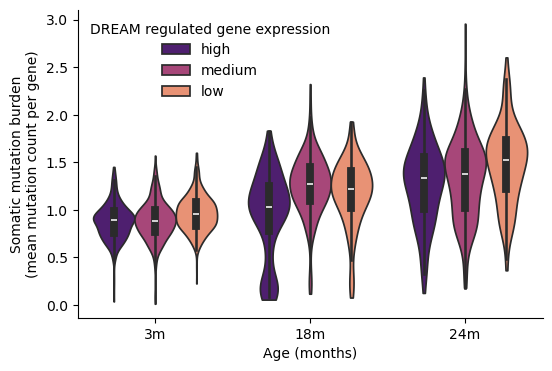

In [153]:
# within each age, bin the mean_dream_activity into 3 bins
fig, axes  = plt.subplots(figsize=(6,4))
facs_raw.obs['dream_activity_bin'] = facs_raw.obs.groupby('age_months')['mean_dream_activity'].transform(
    lambda x: pd.qcut(x, 3, labels = ['low', 'medium', 'high'])
    )

sns.violinplot(
    data = facs_raw.obs.query("cell_type == 'bulge keratinocyte'"), y = 'mutation_count', x = 'age',
    hue = 'dream_activity_bin', palette='magma', 
    hue_order=['high', 'medium', 'low'], cut = 0,
    order = ['3m', '18m', '24m'],# dodge=True, #showfliers = False,
    ax = axes, density_norm="width", common_norm=False,
    )
axes.set_xlabel('Age (months)')
plt.ylabel('Somatic mutation burden\n(mean mutation count per gene)')
plt.legend(title='DREAM regulated gene expression', frameon=False)
sns.despine()

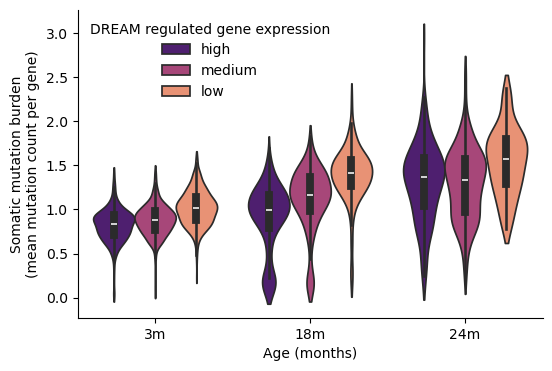

In [346]:
# within each age, bin the mean_dream_activity into 3 bins
fig, axes  = plt.subplots(figsize=(6,4))
facs.obs['dream_activity_bin'] = facs.obs.groupby('age_months')['mean_dream_activity_resid'].transform(
    lambda x: pd.qcut(x, 3, labels = ['low', 'medium', 'high'])
    )

sns.violinplot(
    data = facs.obs.query("cell_type == 'bulge keratinocyte'"), y = 'mutation_count', x = 'age',
    hue = 'dream_activity_bin', palette='magma', dodge=True, 
    hue_order=['high', 'medium', 'low'], cut = 1,
    order = ['3m', '18m', '24m'],# dodge=True, #showfliers = False,
    ax = axes, density_norm="width", common_norm=True,
    )
axes.set_xlabel('Age (months)')
plt.ylabel('Somatic mutation burden\n(mean mutation count per gene)')
plt.legend(title='DREAM regulated gene expression', frameon=False)
sns.despine()

# Negative control background

In [356]:
def get_mean_expression(
    gene_set: list, expr_object: sc.AnnData, regress: bool
    ):
    genes_w_expr = expr_object.var_names
    gene_set_w_expr = list(set(gene_set).intersection(genes_w_expr))
    # get the mean expression of these genes across all cells
    expr_object.obs['mean_expr'] = expr_object[:, gene_set_w_expr].X.mean(axis=1)
    if regress:
        expr_ols = smf.ols(
            formula='mean_expr ~ n_counts * n_genes ', data=expr_object.obs
            ).fit()
        expr_object.obs['mean_expr_resid'] = expr_ols.resid
        expr_object.obs['mean_expr_resid_scaled'] = expr_object.obs['mean_expr_resid'] - min(expr_object.obs['mean_expr_resid'])
        to_return = expr_object.obs['mean_expr_resid_scaled'].copy(deep=True)
        # drop
        expr_object.obs.drop(['mean_expr_resid', 'mean_expr_resid_scaled'], axis=1, inplace=True)
        return to_return
    else:
        to_return = expr_object.obs['mean_expr'].copy(deep=True)
        # drop
        expr_object.obs.drop('mean_expr', axis=1, inplace=True)
        return to_return

def create_random_background(num_iter, expr_object, regress, choose_from = []):
    n_dream_genes_w_expr = len(dream_genes_w_expr) # aka 249
    # randomly choose sets of n_dream_genes_w_expr from facs genes
    random.seed(42)
    if choose_from == []:
        genes_to_choose_from = set(expr_object.var_names)
    else:
        genes_to_choose_from = set(choose_from)
        print(f"using {len(genes_to_choose_from)} provided genes to choose from")
        
    mean_expressions = []
    for i in range(num_iter):
        random_genes = random.sample(genes_to_choose_from, n_dream_genes_w_expr)
        mean_expressions.append(get_mean_expression(random_genes, expr_object, regress))
        
    random_background_mean_expression_df = pd.concat(mean_expressions, axis = 1)
    random_background_mean_expression_df.columns = [f'random_{n}' for n in range(len(mean_expressions))]
    # add necessary cols
    random_background_mean_expression_df['mutation_count'] = expr_object.obs['mutation_count']
    #random_background_mean_expression_df['mutation_count_resid'] = expr_object.obs['mutation_count_resid']
    #random_background_mean_expression_df['mutation_count_resid_scaled'] = expr_object.obs['mutation_count_resid_scaled']
    random_background_mean_expression_df['age_months'] = expr_object.obs['age_months']
    random_background_mean_expression_df['tissue'] = expr_object.obs['tissue']
    random_background_mean_expression_df['subtissue'] = expr_object.obs['subtissue']
    random_background_mean_expression_df['cell_type'] = expr_object.obs['cell_type']
    random_background_mean_expression_df['n_genes'] = expr_object.obs['n_genes']
    random_background_mean_expression_df['n_counts'] = expr_object.obs['n_counts']
    random_background_mean_expression_df['mean_dream_activity'] = expr_object.obs['mean_dream_activity']
    # comment/uncomment for facs_raw/facs
    random_background_mean_expression_df['mean_dream_activity_resid'] = expr_object.obs['mean_dream_activity_resid']

    return random_background_mean_expression_df

In [357]:
ddr_genes = pd.read_csv('/cellar/users/zkoch/dream/utilities/mouse_DNA_damage_response_genes_GO.tsv', sep='\t', index_col = False)
# convert to uppercase
ddr_genes['Symbol'] = ddr_genes['Symbol'].str.upper()
ddr_genes_w_expr = list(set(facs_raw.var.index).intersection(set(ddr_genes['Symbol'])))
num_shared= len(ddr_genes_w_expr)
print(f"number of ddr genes with expression {num_shared} out of {len(set(ddr_genes['Symbol']))} total ddr genes")

number of ddr genes with expression 719 out of 838 total ddr genes


MannwhitneyuResult(statistic=325652.0, pvalue=1.38000862664388e-07)


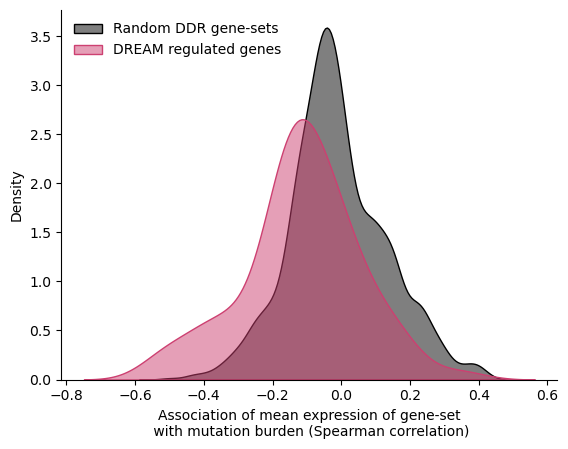

In [247]:
background_df = create_random_background(100, facs_raw, regress = False, choose_from = ddr_genes_w_expr)

# get correlation of random choices with mutation count
raw_corr_df = background_df.groupby(['tissue', 'age_months']).corr(
    method='spearman', numeric_only=True
    )['mutation_count'].reset_index()
raw_corr_df.rename(columns={'level_2':'variable', 'mutation_count':'Spearmanr'}, inplace=True)
# add is_random_background
raw_corr_df['is_random_background'] = raw_corr_df["variable"].str.contains('random')
raw_corr_df.query("variable.str.contains('random') or variable == 'mean_dream_activity'", inplace=True)
sns.kdeplot(data = raw_corr_df, hue = 'is_random_background', x = 'Spearmanr', common_norm=False,fill=True, palette=[magma_categorical(5), 'black'], alpha=.5)
print(mannwhitneyu(
    raw_corr_df.query("variable.str.contains('random')")['Spearmanr'],
    raw_corr_df.query("variable == 'mean_dream_activity'")['Spearmanr']
    ))
plt.xlabel('Association of mean expression of gene-set\n with mutation burden (Spearman correlation)')
# change legend labels
#andles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    ['Random DDR gene-sets', 'DREAM regulated genes'],
    frameon=False, loc='upper left'
    )
sns.despine()

MannwhitneyuResult(statistic=1811089.0, pvalue=6.531242677839496e-14)


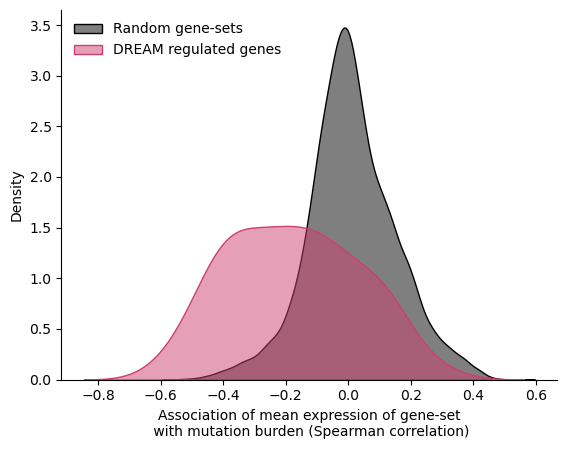

In [358]:
background_df2 = create_random_background(500, facs, regress = True)
background_df2.to_parquet('/cellar/users/zkoch/dream/notebooks/assorted_outputs/facs_500randomBackground_regress.parquet')

# get correlation of random choices with mutation count
raw_corr_df2 = background_df2.groupby(['tissue', 'age_months']).corr(
    method='spearman', numeric_only=True
    )['mutation_count'].reset_index()
raw_corr_df2.rename(columns={'level_2':'variable', 'mutation_count':'Spearmanr'}, inplace=True)
# add is_random_background
raw_corr_df2['is_random_background'] = raw_corr_df2["variable"].str.contains('random')
raw_corr_df2.query("variable.str.contains('random') or variable == 'mean_dream_activity_resid'", inplace=True)
sns.kdeplot(data = raw_corr_df2, hue = 'is_random_background', x = 'Spearmanr', common_norm=False,fill=True, palette=[magma_categorical(5), 'black'], alpha=.5)
print(mannwhitneyu(
    raw_corr_df2.query("variable.str.contains('random')")['Spearmanr'],
    raw_corr_df2.query("variable == 'mean_dream_activity_resid'")['Spearmanr']
    ))
plt.xlabel('Association of mean expression of gene-set\n with mutation burden (Spearman correlation)')
# change legend labels
#andles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    ['Random gene-sets', 'DREAM regulated genes'],
    frameon=False, loc='upper left'
    )
sns.despine()
# save background_df2 to parquet

MannwhitneyuResult(statistic=24167.0, pvalue=0.835086914524183)


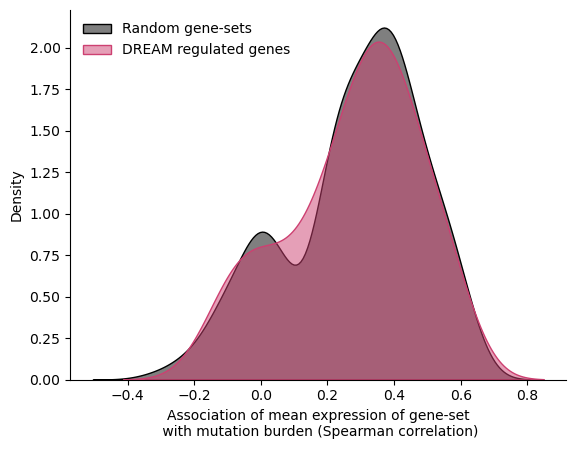

In [264]:
background_df3 = create_random_background(10, facs, regress = False)

# get correlation of random choices with mutation count
raw_corr_df3 = background_df3.groupby(['tissue', 'age_months']).corr(
    method='spearman', numeric_only=True
    )['mutation_count'].reset_index()
raw_corr_df3.rename(columns={'level_2':'variable', 'mutation_count':'Spearmanr'}, inplace=True)
# add is_random_background
raw_corr_df3['is_random_background'] = raw_corr_df3["variable"].str.contains('random')
raw_corr_df3.query("variable.str.contains('random') or variable == 'mean_dream_activity'", inplace=True)
sns.kdeplot(data = raw_corr_df3, hue = 'is_random_background', x = 'Spearmanr', common_norm=False,fill=True, palette=[magma_categorical(5), 'black'], alpha=.5)
print(mannwhitneyu(
    raw_corr_df3.query("variable.str.contains('random')")['Spearmanr'],
    raw_corr_df3.query("variable == 'mean_dream_activity'")['Spearmanr']
    ))
plt.xlabel('Association of mean expression of gene-set\n with mutation burden (Spearman correlation)')
# change legend labels
#andles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    ['Random gene-sets', 'DREAM regulated genes'],
    frameon=False, loc='upper left'
    )
sns.despine()

MannwhitneyuResult(statistic=26858.0, pvalue=0.0787671140990691)


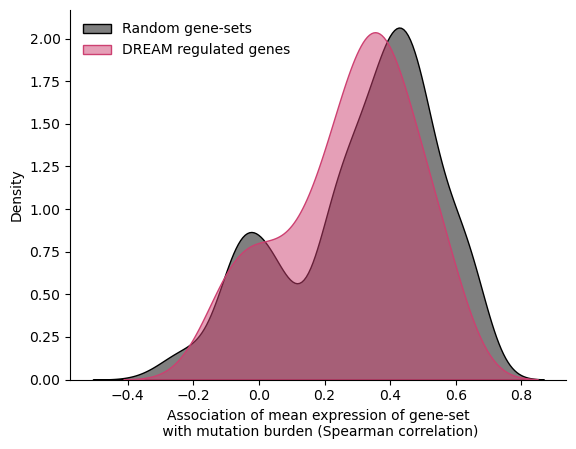

In [265]:
background_df = create_random_background(10, facs, regress = False, choose_from = ddr_genes_w_expr)

# get correlation of random choices with mutation count
raw_corr_df = background_df.groupby(['tissue', 'age_months']).corr(
    method='spearman', numeric_only=True
    )['mutation_count'].reset_index()
raw_corr_df.rename(columns={'level_2':'variable', 'mutation_count':'Spearmanr'}, inplace=True)
# add is_random_background
raw_corr_df['is_random_background'] = raw_corr_df["variable"].str.contains('random')
raw_corr_df.query("variable.str.contains('random') or variable == 'mean_dream_activity'", inplace=True)
sns.kdeplot(data = raw_corr_df, hue = 'is_random_background', x = 'Spearmanr', common_norm=False,fill=True, palette=[magma_categorical(5), 'black'], alpha=.5)
print(mannwhitneyu(
    raw_corr_df.query("variable.str.contains('random')")['Spearmanr'],
    raw_corr_df.query("variable == 'mean_dream_activity'")['Spearmanr']
    ))
plt.xlabel('Association of mean expression of gene-set\n with mutation burden (Spearman correlation)')
# change legend labels
#andles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    ['Random gene-sets', 'DREAM regulated genes'],
    frameon=False, loc='upper left'
    )
sns.despine()